In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## How to segment image data using local thresholds

This notebook meshes an image with multiple domains using `nanomesh`. The image contains a gradient from left to right.  If the image background is relatively uniform, global thresholds can be used to separate the different domains. In this case, the image has a contrast gradient from left to right, so this example shows three different methods to deal with this.

The image is then meshed using `nanomesh` to obtain a mesh with multiple domains. The mesh contains triangles labeled as 'pore' or 'bulk' material.

### Loading and pre-processing the data

The image data is loaded from a numpy file, and apply a gaussian filter to reduce image noise. Notice how the image has a bit of a gradient going from left to right.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<IPython.core.display.Javascript object>


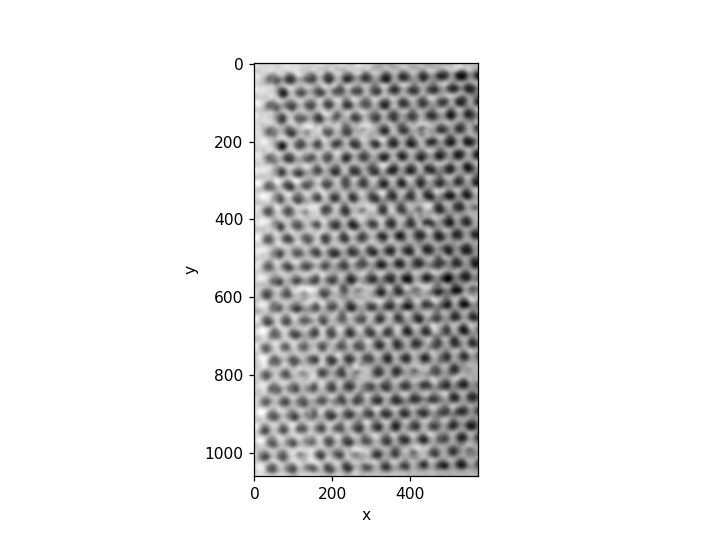

<AxesSubplot:xlabel='x', ylabel='y'>

In [2]:
from nanomesh import Plane
from skimage import filters

plane = Plane.load('x500.npy').gaussian(sigma=5)
plane.show()

Using `filters.try_all_thresholds` is usually a good way to find a useful value to segment the data. In this case, the gradient prevents a useful result.

<IPython.core.display.Javascript object>


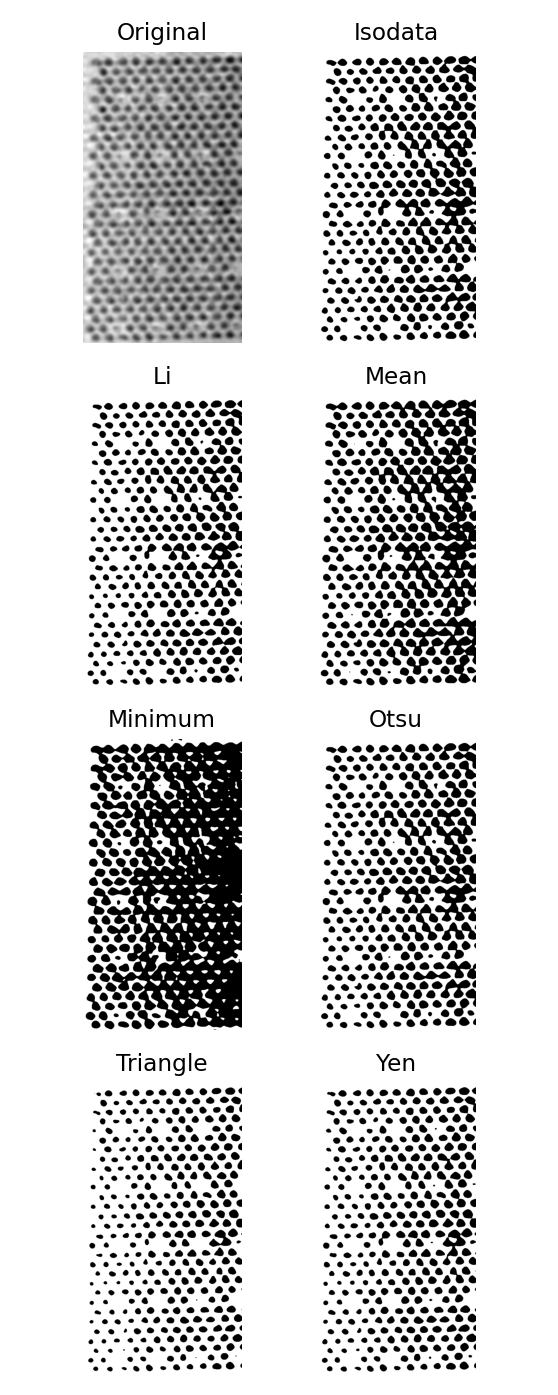

(<Figure size 400x1000 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Original'}>,
        <AxesSubplot:title={'center':'Isodata'}>,
        <AxesSubplot:title={'center':'Li'}>,
        <AxesSubplot:title={'center':'Mean'}>,
        <AxesSubplot:title={'center':'Minimum'}>,
        <AxesSubplot:title={'center':'Otsu'}>,
        <AxesSubplot:title={'center':'Triangle'}>,
        <AxesSubplot:title={'center':'Yen'}>], dtype=object))

In [3]:
plane.try_all_threshold(figsize=(4, 10))

### Local thresholding

This section explores three different methods for local thresholding.

- User-defined local threshold ([api][1], [example][2])
- Otsu local threshold ([api][3], [example][4])
- Adaptive histogram equalization ([api][5], [example][6])

#### User-defined local threshold

In a local threshold filter, the local neighbourhoud is used to define a threshold map for the image. The `block_size` defines the size of the neighbourhood, a 101 by 101 pixel window in this case. The offset is used to tune the map. The advantage of this method is that it is fairly simple. The downside is that it requires manually tuning two parameters (`offset`, `blocksize`) to get a useful result.

[1]: https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_local  
[2]: https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html#local-thresholding
[3]: https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.otsu  
[4]: https://scikit-image.org/docs/stable/auto_examples/applications/plot_rank_filters.html#image-threshold
[5]: https://scikit-image.org/docs/stable/api/skimage.exposure.html#equalize-adapthist  
[6]: https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_local_equalize.html#local-histogram-equalization

<IPython.core.display.Javascript object>


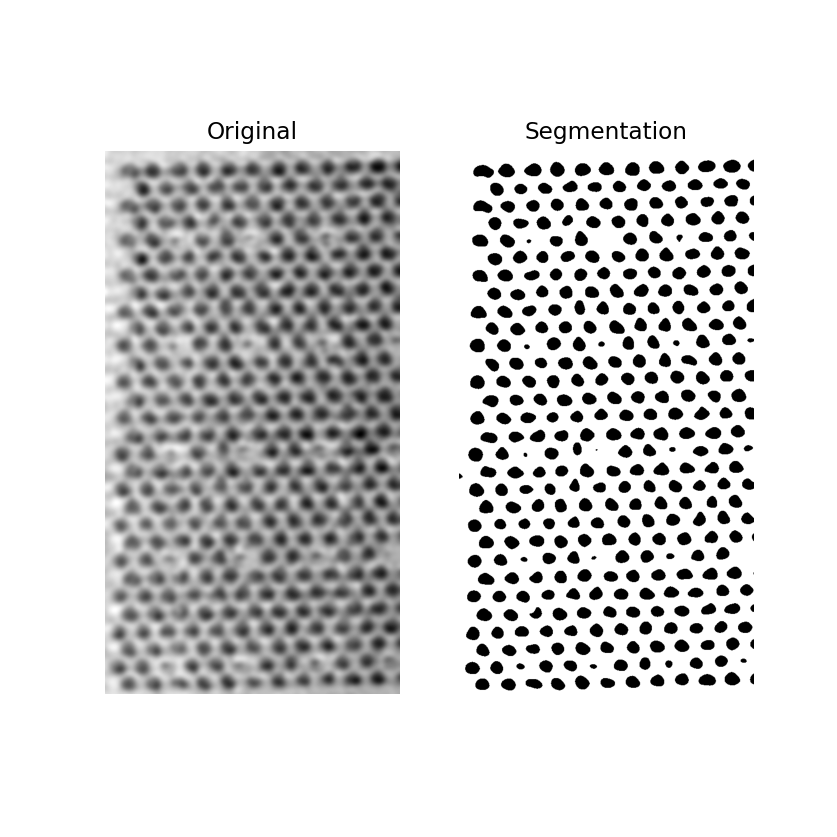

In [4]:
from skimage.filters import threshold_local
import matplotlib.pyplot as plt

offset = 150
block_size = 101

local_thresh = plane.threshold('local', block_size=block_size, offset=offset)
seg_local = plane.image > local_thresh.image

## Plot

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(plane.image)
ax[0].set_title('Original')

ax[1].imshow(seg_local)
ax[1].set_title('Segmentation')

for a in ax:
    a.axis('off')

plt.show()

#### Otsu local threshold

Applies an otsu rank filter to determine the local otsu threshold to segment on. Similar to the global otsu method, but constrained to a small area around each pixel. The advantage of this method that it only requires tuning a single parameter, namely the `radius` of the neighbourhood. The downside is that only the otsu method is available as a rank filter.

<IPython.core.display.Javascript object>


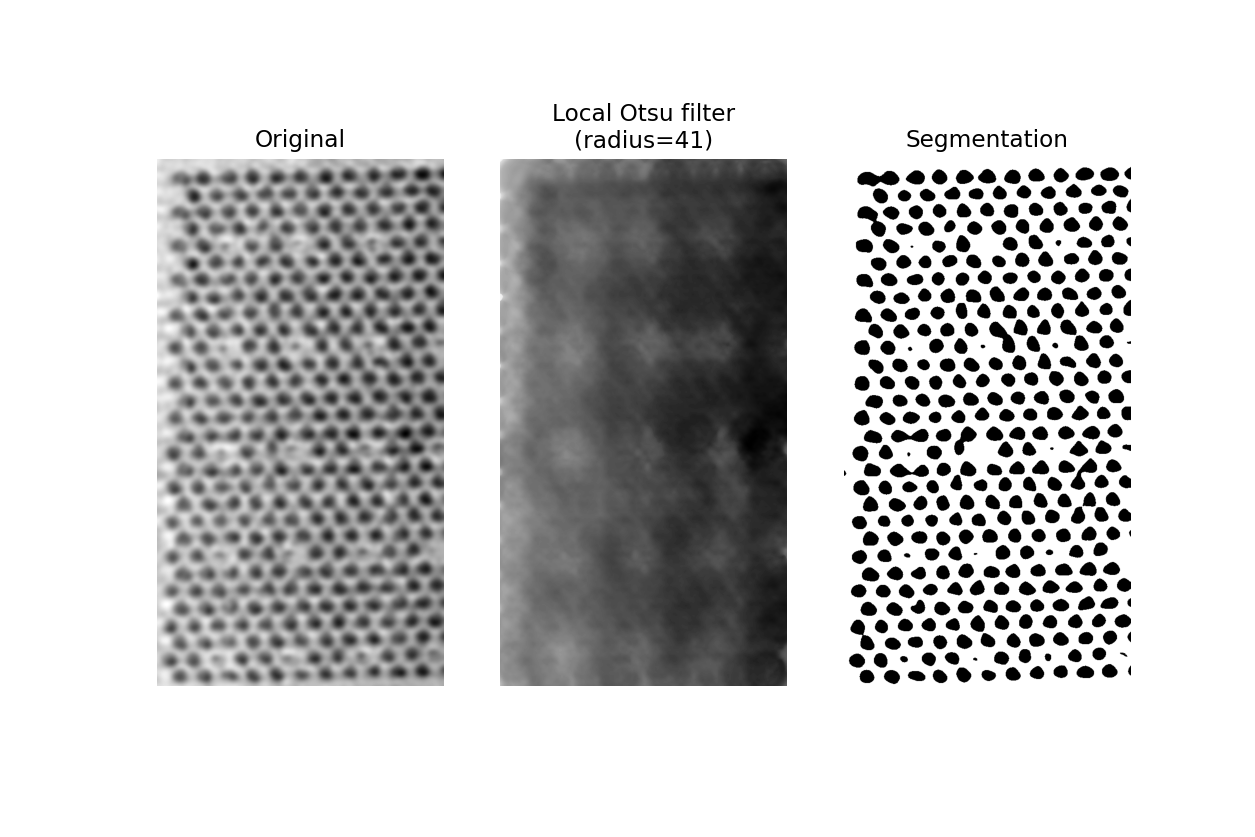

In [5]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

def normalize_values(image):
    return (image - image.min()) / (image.max() - image.min())

image_orig = normalize_values(plane.image)
image = img_as_ubyte(image_orig)

radius = 41
selem = disk(radius)

local_otsu = rank.otsu(image, selem)
seg_local_otsu = image >= local_otsu

## Plot

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(9, 6))
ax = axes.ravel()

ax[0].imshow(plane.image)
ax[0].set_title('Original')

ax[1].imshow(local_otsu)
ax[1].set_title(f'Local Otsu filter\n(radius={radius})')

ax[2].imshow(seg_local_otsu)
ax[2].set_title('Segmentation')

for a in ax:
    a.axis('off')

plt.show()

#### Adaptive histogram equalization

This method tries to correct the image by removing the local gradient first, using adaptive histogram equalization. The advantage is that all global threshold finders are available. Another advantage is that there are no parameters to tune. At the same time, this is also a disadvantage if the result is not good 😉

<IPython.core.display.Javascript object>


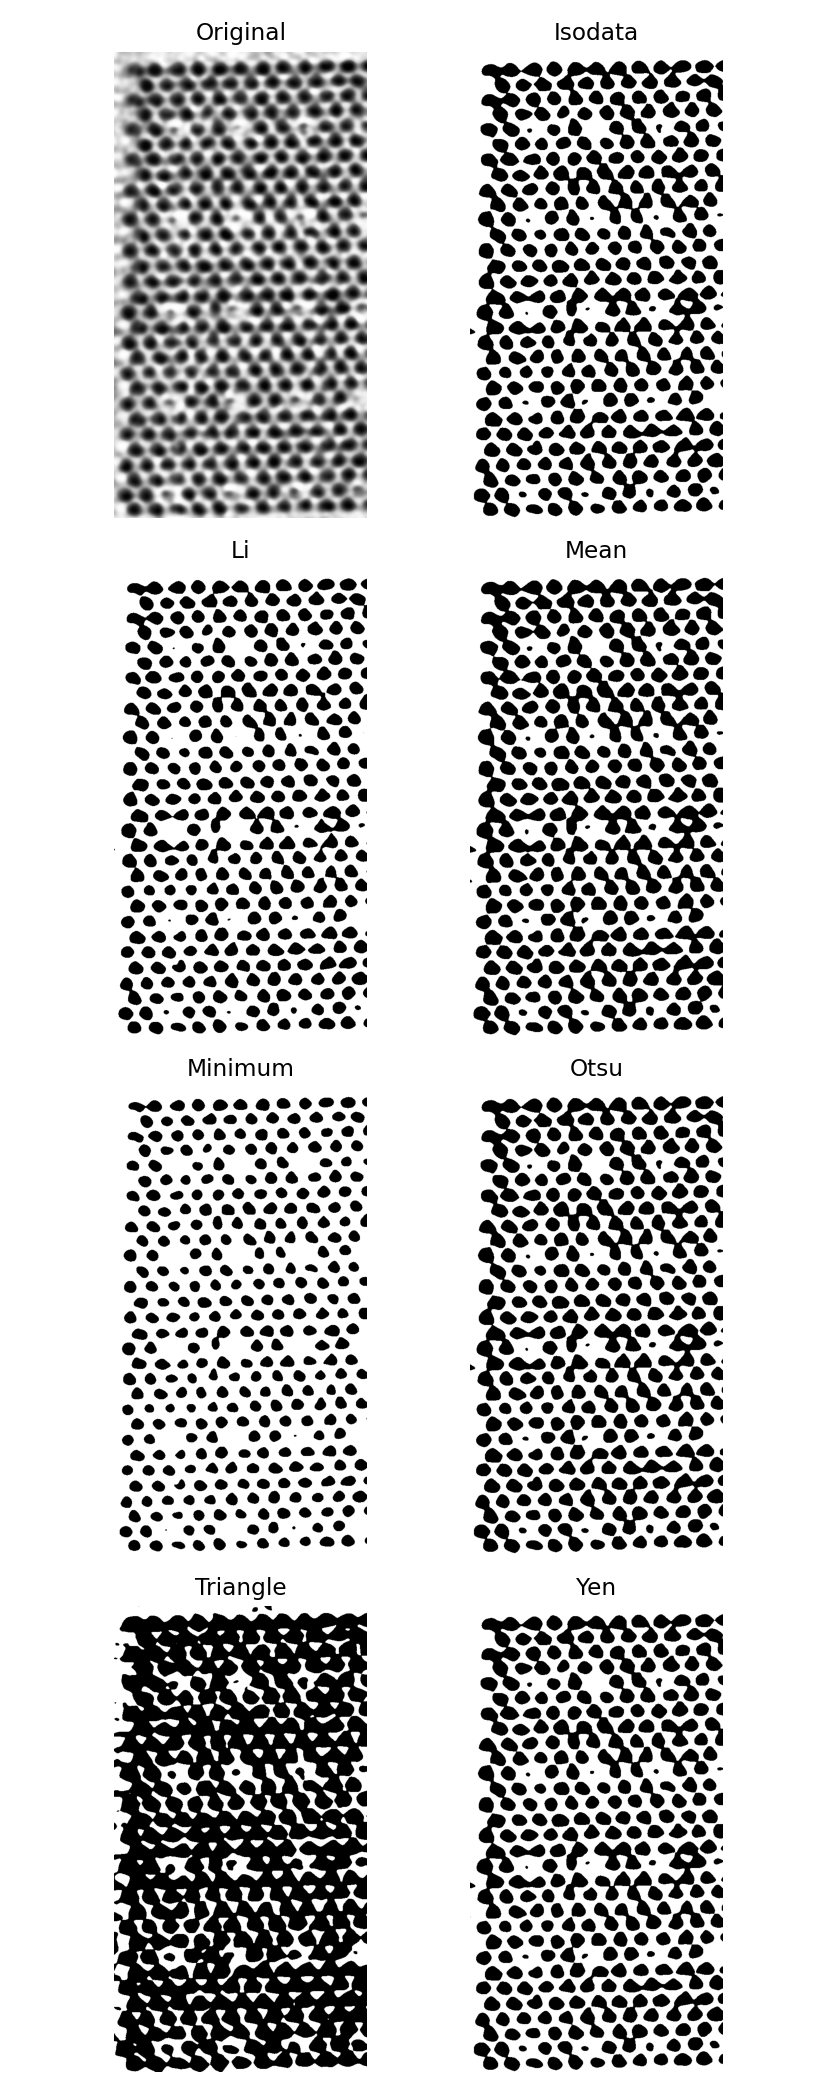

(<Figure size 600x1500 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Original'}>,
        <AxesSubplot:title={'center':'Isodata'}>,
        <AxesSubplot:title={'center':'Li'}>,
        <AxesSubplot:title={'center':'Mean'}>,
        <AxesSubplot:title={'center':'Minimum'}>,
        <AxesSubplot:title={'center':'Otsu'}>,
        <AxesSubplot:title={'center':'Triangle'}>,
        <AxesSubplot:title={'center':'Yen'}>], dtype=object))

In [6]:
from skimage import exposure
import numpy as np

plane_eq = plane.apply(normalize_values)
plane_eq = plane_eq.apply(exposure.equalize_adapthist)

filters.try_all_threshold(plane_eq.image, figsize=(6, 15), verbose=False)

### Compare results

The next cell creates a plot that compares the result of all three methods. For the histogram equalization, the *Otsu* and *Li* filters are shown.

<IPython.core.display.Javascript object>


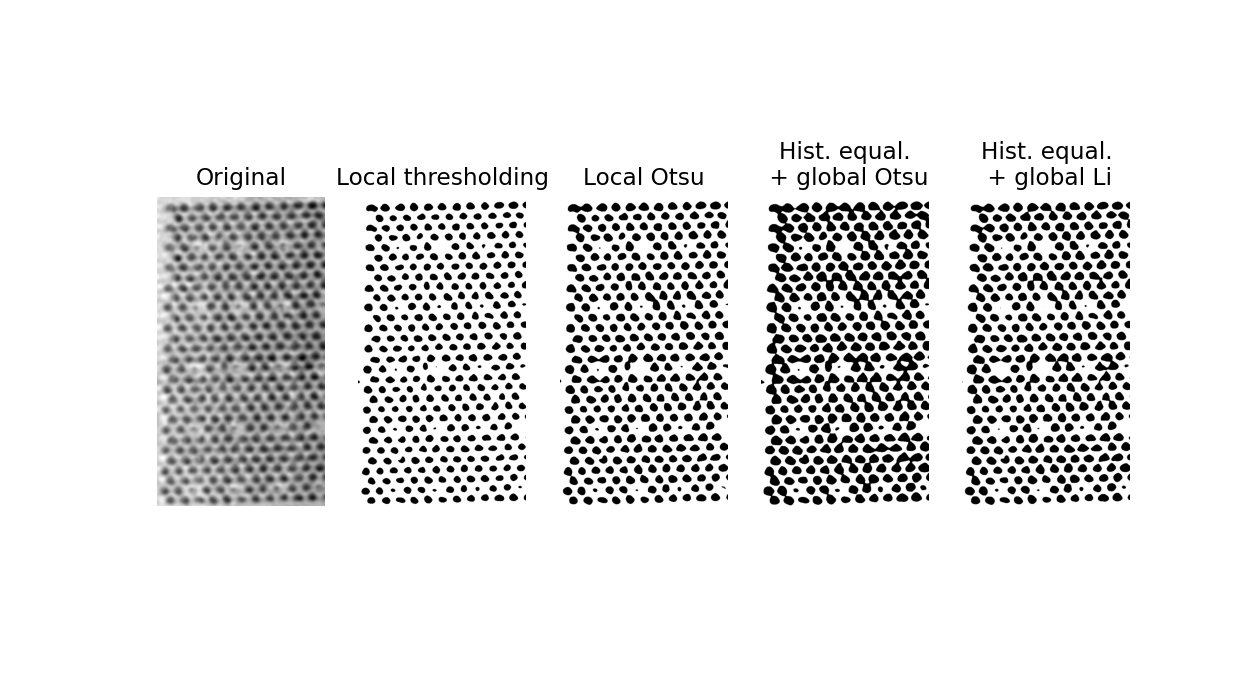

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=5, figsize=(9, 5))
ax = axes.ravel()

ax[0].imshow(plane.image)
ax[0].set_title('Original')

ax[1].imshow(seg_local)
ax[1].set_title('Local thresholding')

ax[2].imshow(seg_local_otsu)
ax[2].set_title('Local Otsu')

seg_clahe_otsu = plane_eq.binary_digitize(threshold='otsu')

ax[3].imshow(seg_clahe_otsu.image)
ax[3].set_title('Hist. equal.\n + global Otsu')

seg_clahe_li = plane_eq.binary_digitize(threshold='li')

ax[4].imshow(seg_clahe_li.image)
ax[4].set_title('Hist. equal.\n + global Li')

for a in ax:
    a.axis('off')

plt.show()

### Meshing the image data

Finally, it's time to mesh the image. 

Triangulation has some issues with small elements near the border, so these will be cleared first.

In [8]:
from skimage import segmentation

# convert from bool to int
image = seg_local.astype(int)
image = segmentation.clear_border(~image)

<IPython.core.display.Javascript object>


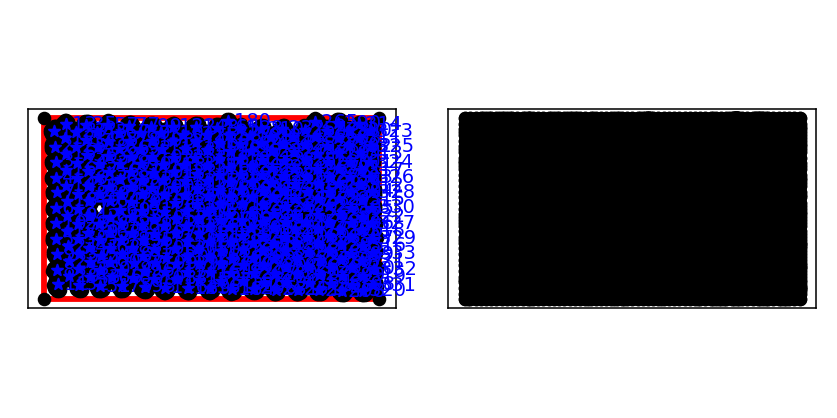

Wall time: 5.51 s


In [9]:
%%time

from nanomesh.mesh2d import Mesher2D

mesher = Mesher2D(image)
mesher.generate_contours(max_contour_dist = 4)

mesh = mesher.triangulate(opts='q30a100', plot=True)

View the result using `itkwidgets`:

In [10]:
mesh.plot_itk()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Save the data:

In [11]:
mesh.write("mesh_x500_ascii.msh", file_format='gmsh22', binary=False)

msh2 requires 3D points, but 2D points given. Appending 0 third component.
Appending zeros to replace the missing physical tag data.
Appending zeros to replace the missing geometrical tag data.
